Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# import csv and show head
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# look for nulls and check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
# no nulls
# change version datatype to category for quick processing
df['version'] = df.version.astype('category')

Data dictionary
    userid (int) - unique id for each user
    version (category) - version of the game they played (either gate at level 30 or gate at level 40)
    sum_gamerounds (int) - rounds played
    retention_1 (bool) - did the player come back and play 1 day after installing?
    retention_7 (bool) - did the player come back and play 7 days after installing?

In [5]:
# is your understanding correct, do some sanity checks

# user_id --> unique or not?
print("Is userid unique:",df.userid.nunique() == df.shape[0])

# version --> only two? is naming consistent?
print("Versions:", tuple(df.version.unique()))

# sum_gamerounds --> are there any weird values
display(df.sum_gamerounds.describe())

Is userid unique: True
Versions: ('gate_30', 'gate_40')


count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [6]:
# retention_1, retention_7 --> let's assign retention levelss for each case
# RETENTION_LEVELS = ['No retention', 'Some retention', 'High retention']
# def assign_retention_levels(df):
#     if (df.retention_1 == True) and (df.retention_7 == True):
#         return RETENTION_LEVELS[2]
#     elif (df.retention_1 == False) and (df.retention_7 == False):
#         return RETENTION_LEVELS[0]
#     else:
#         return RETENTION_LEVELS[1]
    
# df['retention_level'] = df.apply(assign_retention_levels, axis=1)

# df['retention_level'] = pd.Categorical(df['retention_level'], categories = RETENTION_LEVELS, ordered=True)

# df['retention_level']

# retention_1, retention_7 --> let's assign retention levelss for each case
def assign_retention_levels(df):
    return (df.retention_1 == True) and (df.retention_7 == True)
    
df['retention_level'] = df.apply(assign_retention_levels, axis=1)

df['retention_level']

0        False
1        False
2        False
3        False
4         True
         ...  
90184    False
90185    False
90186    False
90187    False
90188    False
Name: retention_level, Length: 90189, dtype: bool

Text(0.5, 1.0, 'Retention levels for each version of the game')

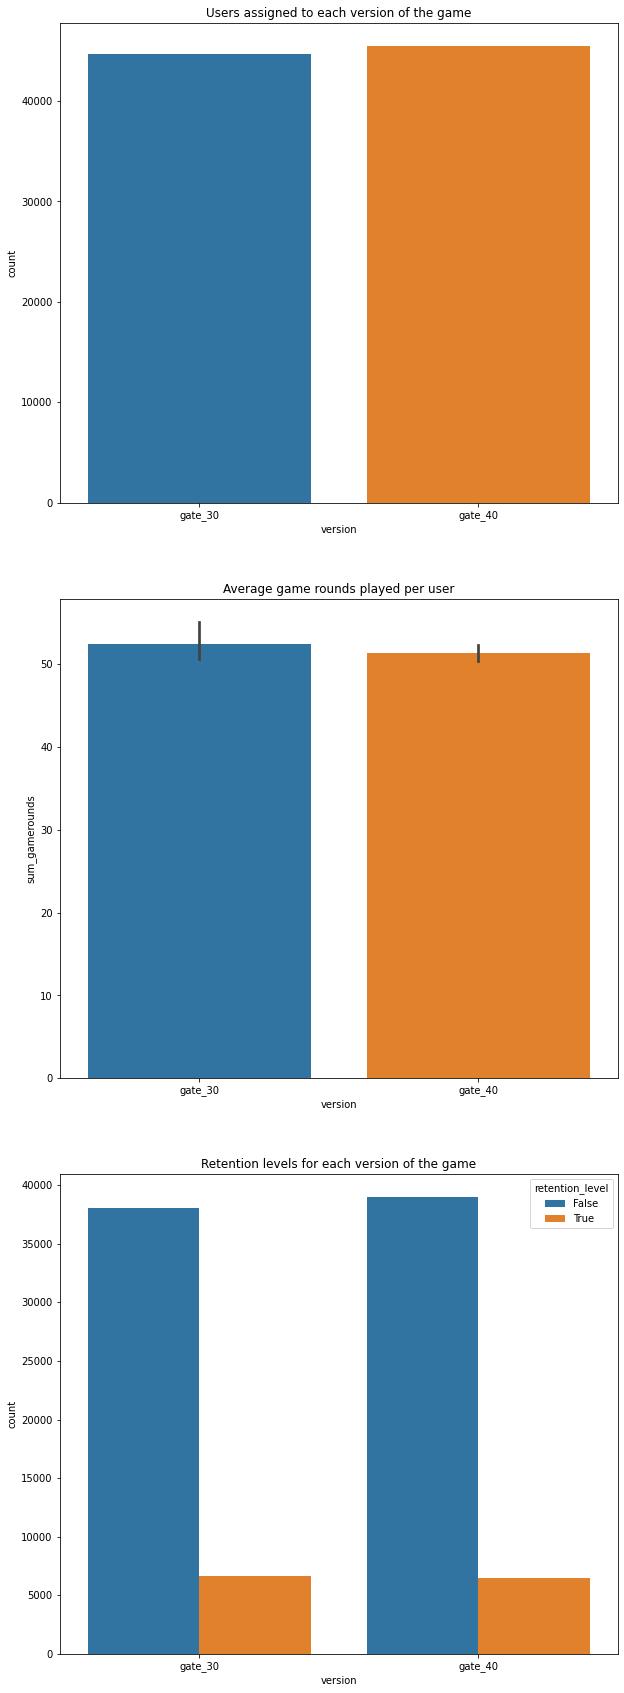

In [7]:
# Graphical EDA
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))

# amt of people in each group
sns.countplot(data=df, x='version', ax=ax1)
ax1.set_title('Users assigned to each version of the game')
# how many games does each group play on average
sns.barplot(data=df, x='version', y='sum_gamerounds', ax=ax2)
ax2.set_title('Average game rounds played per user')
# retention levels in each group
sns.countplot(data=df, x='version', hue='retention_level', ax=ax3)
ax3.set_title('Retention levels for each version of the game')

1. Users are equally assigned to each version
2. Users played more rounds on average in version gate_30 (still we have to test this)
3. The retention compositions for both versions look very similar (let's find a way to quantify this)

In [125]:
# A/B test

df_a = df[df.version == 'gate_30']
df_b = df[df.version == 'gate_40']

In [126]:
# Null hyp: no diff in rounds played
# Test stat: diff in rounds played

# Observed difference
diff_gamerounds_obs = df_a.sum_gamerounds.mean() - df_b.sum_gamerounds.mean()

# Generate permutation samples and replicates
def gen_perm_replicates(n:int, df:pd.DataFrame, agg, col:str, len_a:int, len_b:int):
    '''
    Generates permutation samples from a df col
    n - samples to generate
    df - DataFrame to slice
    col - column name from the dataframe of interest
    agg: function - agg function to summarize
    len_a - length of A
    len_b - lenght of B
    
    Returns an array of perm replicates which are the diff of the agg function between a and b
    '''
    # input validation
    assert len_a + len_b == len(df), "A + B size must be equal to number of df rows"
    
    # init result array
    replicates = np.empty(n)
    
    # get column of interest as an array
    original_array = np.array(df[col])

    # for each sample
    for i in range(n):
        # generate sample
        temp_array = np.random.permutation(original_array)
        # calculate permutation replicate
        a = temp_array[:len_a]
        b = temp_array[len_a:]
        replicate = agg(a) - agg(b)
        # add to replicates
        replicates[i] = replicate
        
    return replicates


diff_gamerounds_replicates = gen_perm_replicates(5000, df, np.mean, 'sum_gamerounds', len(df_a), len(df_b))

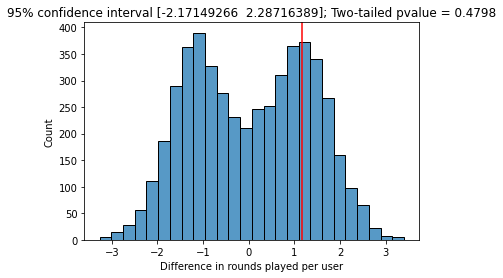

In [141]:
# Compare the observed stats to perm replicates
def obs_vs_replicates(obs, replicates, xlabel):
    fig, ax = plt.subplots()
    sns.histplot(replicates, ax=ax)
    
    if obs > 0:
        pval = (np.sum(replicates >= obs) + np.sum(replicates <= -1*obs)) / len(replicates)
    else:
        pval = (np.sum(replicates <= obs) + np.sum(replicates >= -1*obs)) / len(replicates)
        
    ax.axvline(x=obs, color='r')
    ax.set_xlabel(xlabel)
    ax.set_title("95% confidence interval "+str(np.percentile(replicates, [2.5,97.5]))+"; Two-tailed pvalue = "+str(pval))
    plt.show()

obs_vs_replicates(diff_gamerounds_obs, diff_gamerounds_replicates, 'Difference in rounds played per user')

In [139]:
np.sum(diff_gamerounds_replicates >= 0.5)

2096

In [120]:
# define retention ratio

# Null hyp: no diff full retention ratio
# Test stat: diff in rounds played

# Observed difference
diff_retention_obs = df_a.retention_level.mean() - df_b.retention_level.mean()

# Generate permutation samples and replicates
diff_retention_replicates = gen_perm_replicates(5000, df, np.mean, 'retention_level', len(df_a), len(df_b))

array([ 0.00335588,  0.00433168,  0.0002954 , ..., -0.00059169,
        0.00033976,  0.00042847])

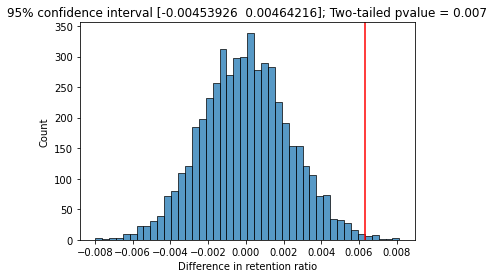

In [142]:
# Compare the observed stats to perm replicates
obs_vs_replicates(diff_retention_obs, diff_retention_replicates, 'Difference in retention ratio')

First door at lv30 (A) vs lv40 (B)
- No statistical evidence that users w/ version A played more rounds than version B
- We can reject the null hypothesis that there's no difference in retention levels
- A retains more user B and this wasn't because of random chance
- But practical significance may not be that high, only a 0.6% increase.